In [1]:
import cached
import cpr_gym
import git
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import psutil
import seaborn as sns
import threadpoolctl
import time
import torch
import warnings
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

tqdm.pandas()
torch.set_num_threads = 1

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
os.chdir(repo.working_tree_dir)

cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = aft23-41-g32d293d-dirty (engine: aft23-40-g10ed11a-dirty)
cpr_lib_version: aft23-40-g10ed11a-dirty


In [2]:
episode_len = 2048
n_episodes = 100
batches = [
    # "2023-10-31_dag-voting-2",
    # "2023-11-01_dag-voting-4",
    # "2023-11-02_dag-voting-5",
    # "2023-11-03_dag-voting-6",
    # "2023-11-05_dag-voting-7",
    # above batches might have other model size or k != 8
    "2023-11-08_dag-voting-8",
    "2023-11-09_dag-voting-9",
    "2023-11-11_dag-voting-10",
    "2023-11-13_dag-voting-11",
    "2023-11-17_dag-voting-12",
]

protocol_args = dict(
    nakamoto=[],
    bk=["k", "reward"],
    tailstorm=["k", "reward", "subblock_selection"],
    tailstormjune=["k", "reward"],
    spar=["k", "reward"],
    stree=["k", "reward", "subblock_selection"],
    sdag=["k", "reward", "subblock_selection"],
)

env_name = "cpr_gym:cpr-v0"


def env_kwargs_of_row(x):
    return dict(
        protocol=x.family,
        protocol_args={k: x[k] for k in protocol_args[x.family]},
        alpha=x.alpha if "alpha" in x.keys() else 0,
        gamma=x.gamma if "gamma" in x.keys() else 0,
        defenders=42,
    )

# Data generation

## Find trained models

In [3]:
def models():
    for batch in batches:
        for m in pathlib.Path(f"data/models/{batch}").glob("ppo-*.zip"):
            frag = m.stem.split("-")
            family = frag.pop(1)

            ent_coef = 0
            for i, x in enumerate(frag):
                if x.startswith("entcoef"):
                    ent_coef = float(x.removeprefix("entcoef"))
                    frag.pop(i)

            learning_rate = "linear:1e-3"
            for i, x in enumerate(frag):
                if x.startswith("lr"):
                    learning_rate = x.removeprefix("lr")
                    frag.pop(i)

            shape = "raw"
            for i, x in enumerate(frag):
                if x in ["raw", "exp", "cut"]:
                    shape = x
                    frag.pop(i)

            if family == "nakamoto":
                yield dict(
                    protocol="nakamoto",
                    family=family,
                    k=1,
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    batch=batch,
                    learning_rate=learning_rate,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            elif family in ["bk", "spar"]:
                k = int(frag.pop(1))
                yield dict(
                    protocol=f"{family}-{k}",
                    family=family,
                    k=k,
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    batch=batch,
                    learning_rate=learning_rate,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            elif family in ["tailstorm", "stree", "sdag"]:
                k = int(frag.pop(1))
                reward = frag.pop(1)
                yield dict(
                    protocol=f"{family}-{k}-{reward}",
                    family=family,
                    k=k,
                    reward=reward,
                    subblock_selection="heuristic",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    batch=batch,
                    learning_rate=learning_rate,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            else:
                raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models())
models = models.assign(
    kind="trained",
    ent_coef=models.ent_coef.map(float),
    learning_rate=models.learning_rate.map(float),
)

In [4]:
# this is what I want to present in the dag-voting paper
def grid():
    for p in ["nakamoto", "spar-8", "stree-8-discount", "sdag-8-discount"]:
        for g in [0.05, 0.5, 0.95]:
            for a in [0.45, 0.4, 0.35, 0.3, 0.25]:
                for ec in [0.001, 0.005, 0.01]:
                    for lr in [0.0003, 0.001]:
                        yield dict(
                            protocol=p, gamma=g, alpha=a, ent_coef=ec, learning_rate=lr
                        )


grid = pd.DataFrame(grid())

flt = {col: list(grid[col].drop_duplicates()) for col in list(grid.columns)}
q = " and ".join([f"{col} in {str(values)}" for col, values in flt.items()])

flt_models = models.query(q)

print(
    f"There are {len(models)} models overall. The target grid has {len(grid)} entries. {len(flt_models)} models fit into the grid."
)

There are 360 models overall. The target grid has 360 entries. 360 models fit into the grid.


missing models


,protocol,gamma,alpha,ent_coef,learning_rate,n_models,batches
0,nakamoto,0.05,0.45,0.001,0.0003,0,
1,nakamoto,0.05,0.45,0.001,0.0010,0,
2,nakamoto,0.05,0.45,0.005,0.0003,0,
3,nakamoto,0.05,0.45,0.005,0.0010,0,
4,nakamoto,0.05,0.45,0.010,0.0003,0,
...,...,...,...,...,...,...,...
325,sdag-8-discount,0.50,0.25,0.001,0.0010,0,
326,sdag-8-discount,0.50,0.25,0.005,0.0003,0,
327,sdag-8-discount,0.50,0.25,0.005,0.0010,0,
328,sdag-8-discount,0.50,0.25,0.010,0.0003,0,


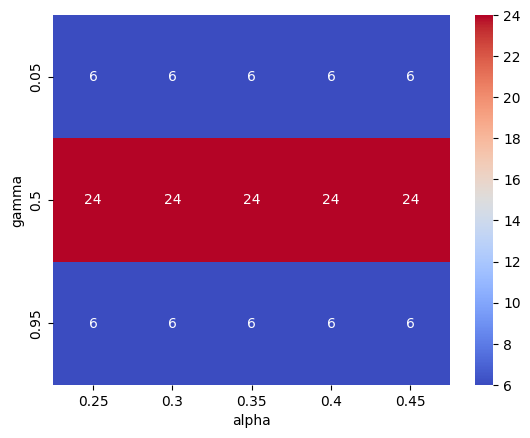

In [5]:
def count(key):
    q = " and ".join([f"{col} == {repr(value)}" for col, value in key.items()])
    d = flt_models.query(q)
    return dict(n_models=len(d), batches=", ".join(list(d.batch.drop_duplicates())))


egrid = grid.join(grid.apply(count, axis=1, result_type="expand"))

redundant = egrid.query("n_models > 2")
if len(redundant) > 0:
    print("redundant models")
    display(redundant)

missing = egrid.query("n_models < 2")
if len(missing) > 0:
    print(f"missing models")
    display(missing)

    sns.heatmap(
        pd.crosstab(missing["gamma"], missing["alpha"]), annot=True, cmap="coolwarm"
    )

In [6]:
models = flt_models
# reuse some trained models for other settings


def neighbors(vec):
    lst = sorted(list(vec.drop_duplicates()))
    for i, x in enumerate(lst):
        if i > 0:
            yield (x, lst[i - 1])
        if i < len(lst) - 1:
            yield (x, lst[i + 1])


more_models = pd.concat(
    [models.assign(reuse="-")]
    + [
        models.query(f"alpha == {orig}").assign(
            reuse=f"alpha{int(orig*100)}", alpha=reusefor
        )
        for orig, reusefor in neighbors(grid.alpha)
    ]
    + [
        models.query(f"gamma == {orig}").assign(
            reuse=f"gamma{int(orig*100)}", gamma=reusefor
        )
        for orig, reusefor in neighbors(grid.gamma)
    ]
)
models = more_models.assign(reused=[x != "-" for x in more_models.reuse])

## Find hard-coded policies

In [7]:
def hard_coded_policies(models):
    for _idx, x in (
        models[
            [
                "protocol",
                "family",
                "k",
                "reward",
                "subblock_selection",
                "gamma",
                "alpha",
            ]
        ]
        .drop_duplicates()
        .iterrows()
    ):
        kwargs = env_kwargs_of_row(x)
        env = gym.make(env_name, **kwargs)
        for p in env.policies():
            x = x.copy()
            x["policy"] = p
            yield x


hard_coded_policies = (
    pd.DataFrame(hard_coded_policies(models))
    .reset_index(drop=True)
    .assign(kind="hard-coded", path="n/a", reuse="-", reused=False)
    .query('family != "nakamoto" or (policy in ["sapirshtein-2016-sm1", "honest"])')
    .query("policy != 'avoid-loss'")
)

hard_coded_policies
# hard_coded_policies.drop(columns=["alpha", "gamma"]).drop_duplicates()

,protocol,family,k,reward,subblock_selection,gamma,alpha,policy,kind,path,reuse,reused
1,stree-8-discount,stree,8,discount,heuristic,0.95,0.40,minor-delay,hard-coded,n/a,-,False
2,stree-8-discount,stree,8,discount,heuristic,0.95,0.40,override-catchup,hard-coded,n/a,-,False
3,stree-8-discount,stree,8,discount,heuristic,0.95,0.40,override-block,hard-coded,n/a,-,False
4,stree-8-discount,stree,8,discount,heuristic,0.95,0.40,release-block,hard-coded,n/a,-,False
5,stree-8-discount,stree,8,discount,heuristic,0.95,0.40,honest,hard-coded,n/a,-,False
...,...,...,...,...,...,...,...,...,...,...,...,...
205,sdag-8-discount,sdag,8,discount,heuristic,0.50,0.45,override-block,hard-coded,n/a,-,False
206,sdag-8-discount,sdag,8,discount,heuristic,0.50,0.45,release-block,hard-coded,n/a,-,False
207,sdag-8-discount,sdag,8,discount,heuristic,0.50,0.45,honest,hard-coded,n/a,-,False
208,spar-8,spar,8,constant,n/a,0.50,0.40,selfish,hard-coded,n/a,-,False


## Run simulations

In [8]:
models_and_hard_coded_policies = pd.concat(
    [models, hard_coded_policies], ignore_index=True
)


def episodes():
    for i in range(0, n_episodes):
        yield models_and_hard_coded_policies.assign(episode=i)


episodes = pd.concat(episodes(), ignore_index=True)

In [9]:
def measure_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = episode_len
    kwargs["seed"] = getattr(x, "episode", None)
    if x.kind == "trained":
        with warnings.catch_warnings():
            warnings.filterwarnings(
                action="ignore", category=UserWarning, lineno=458
            )  # transition to sb3 v1.7
            res = cached.measure_trained(env_name, x.path, **kwargs)
    elif x.kind == "hard-coded":
        res = cached.measure_hardcoded(env_name, x.policy, **kwargs)
    else:
        assert False
    return pd.Series(res)


def parallel_measure(df, fun=measure_row, n_jobs=-1):
    res = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(fun)(row) for idx, row in tqdm(df.iterrows(), total=len(df))
    )
    return pd.concat([df, pd.DataFrame(res)], axis=1)


episodes = parallel_measure(episodes, n_jobs=6)

# list(episodes.columns)

  0%|          | 0/147600 [00:00<?, ?it/s]

In [10]:
# save episode data for re-use in other notebooks
episodes.to_pickle("experiments/rl-eval/episodes.pkl")

# Find optimal policies

In [11]:
scenario = [
    "protocol",
    "family",
    "k",
    "reward",
    "subblock_selection",
    "alpha",
    "gamma",
    "kind",
    "reused",
]
policy = ["policy", "path"]
# d = episodes.query("kind=='hard-coded'")
d = episodes
opt_means = (
    d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
    .groupby(scenario + policy, as_index=False)
    .episode_reward.mean()
)
opt_policies = (
    opt_means.loc[opt_means.groupby(scenario).episode_reward.idxmax()]
    .drop(columns=["episode_reward"])
    .reset_index(drop=True)
)
display(opt_policies.drop(columns=["path"]))

opt_episodes = opt_policies.join(d.set_index(scenario + policy), on=scenario + policy)
# display("opt_episodes columns", list(opt_episodes.columns))

,protocol,family,k,reward,subblock_selection,alpha,gamma,kind,reused,policy
0,sdag-8-discount,sdag,8,discount,heuristic,0.25,0.05,hard-coded,False,honest
1,sdag-8-discount,sdag,8,discount,heuristic,0.25,0.05,trained,False,ppo-oui643qy-last
2,sdag-8-discount,sdag,8,discount,heuristic,0.25,0.05,trained,True,ppo-rqhyo8fn-best
3,sdag-8-discount,sdag,8,discount,heuristic,0.25,0.50,hard-coded,False,honest
4,sdag-8-discount,sdag,8,discount,heuristic,0.25,0.50,trained,True,ppo-nla3lbvt-last
...,...,...,...,...,...,...,...,...,...,...
115,stree-8-discount,stree,8,discount,heuristic,0.45,0.50,hard-coded,False,honest
116,stree-8-discount,stree,8,discount,heuristic,0.45,0.50,trained,True,ppo-4zubbp9e-best
117,stree-8-discount,stree,8,discount,heuristic,0.45,0.95,hard-coded,False,honest
118,stree-8-discount,stree,8,discount,heuristic,0.45,0.95,trained,False,ppo-1swniyvr-best


# Compare RL against best hard-coded

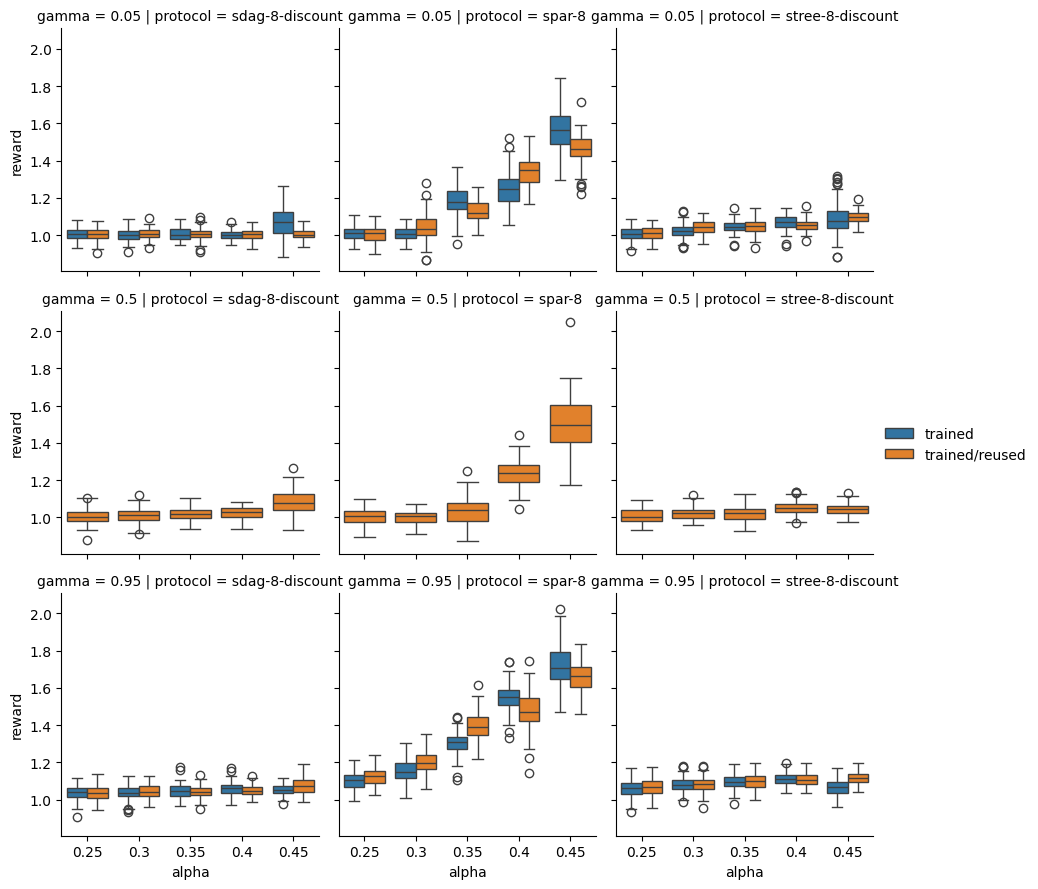

In [12]:
def rl_vs_hard_coded_bp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = d.query('kind != "hard-coded"')
    d = (
        d.assign(
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.FacetGrid(
        data=d,
        # data=d.query("alpha >= .35"),
        col="protocol",
        row="gamma",
        sharex=True,
        sharey=True,
    )
    g.map_dataframe(
        sns.boxplot,
        x="alpha",
        y=label,
        hue="kind",
        orient="v",
        palette="tab10",
    )
    g.add_legend()


## reward per progess (in DAA equilibrium)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress)
## alpha normalizations
rl_vs_hard_coded_bp(lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress - d.alpha)

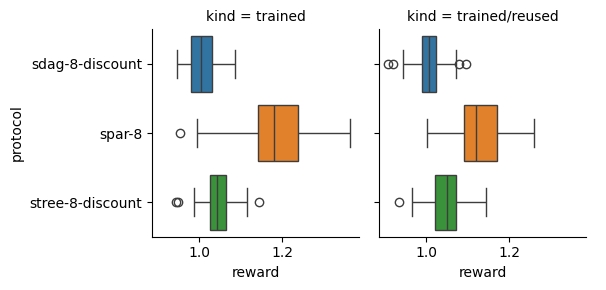

In [13]:
def rl_vs_hard_coded_bp_zoom(objective, gamma=0.05, alpha=0.35, label="reward"):
    d = opt_episodes.query(f"alpha == {alpha} and gamma == {gamma}")
    d.loc[d.reused, "kind"] = "trained/reused"
    d = d.query('kind != "hard-coded"')
    d = (
        d.assign(
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.FacetGrid(
        data=d,
        # data=d.query("alpha >= .35"),
        col="kind",
        sharex=True,
        sharey=True,
    )
    g.map_dataframe(
        sns.boxplot,
        y="protocol",
        x=label,
        hue="protocol",
        orient="h",
        palette="tab10",
    )
    g.add_legend()


## reward per progess (in DAA equilibrium)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress)
## alpha normalizations
rl_vs_hard_coded_bp_zoom(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress - d.alpha)

In [14]:
opt_policies.query('family == "stree" and gamma==0.95 and alpha==.45').drop(
    columns=["path"]
)

,protocol,family,k,reward,subblock_selection,alpha,gamma,kind,reused,policy
117,stree-8-discount,stree,8,discount,heuristic,0.45,0.95,hard-coded,False,honest
118,stree-8-discount,stree,8,discount,heuristic,0.45,0.95,trained,False,ppo-1swniyvr-best
119,stree-8-discount,stree,8,discount,heuristic,0.45,0.95,trained,True,ppo-cekq59yo-last


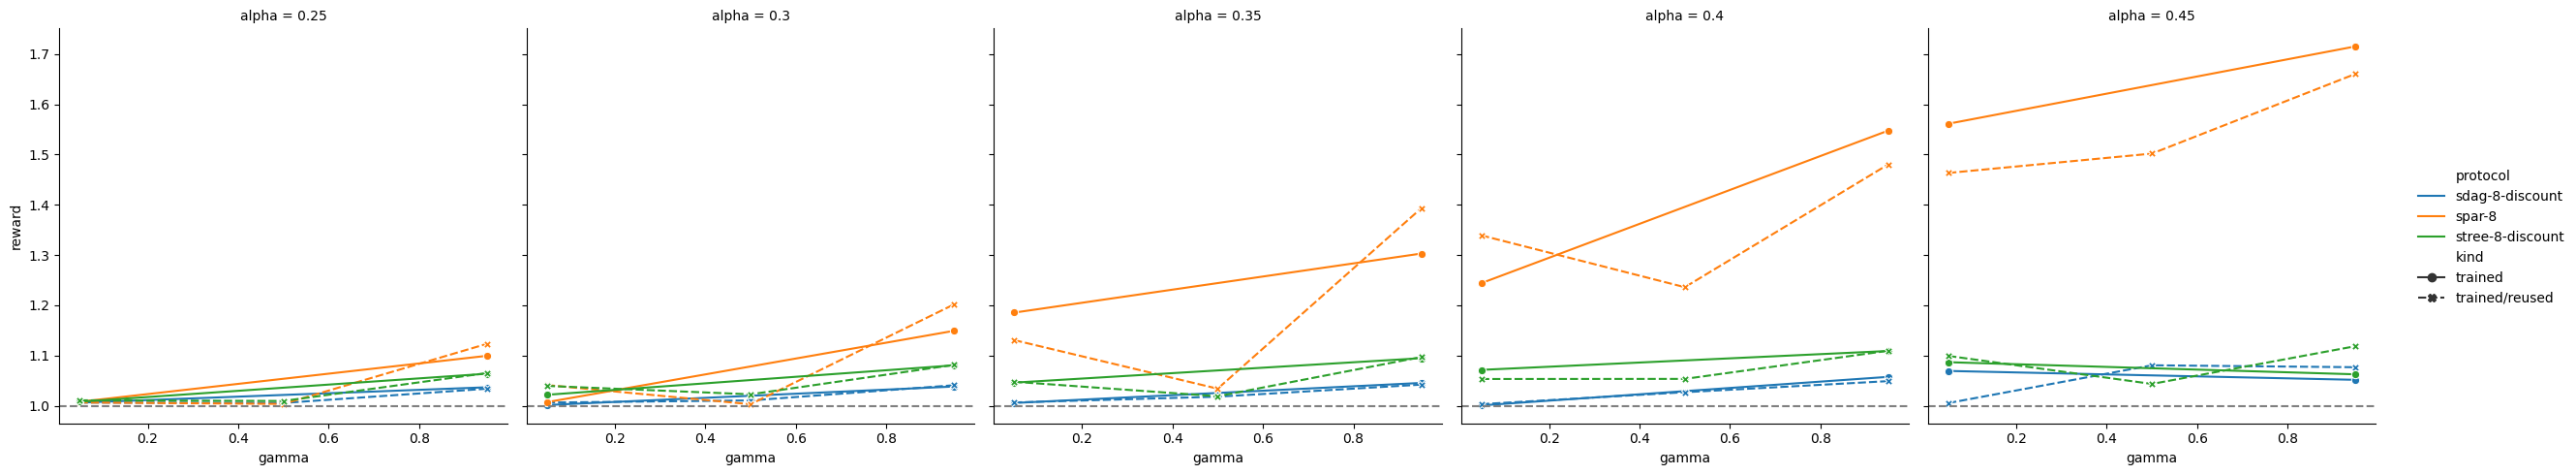

In [15]:
def rl_vs_hard_coded_gamma_lp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = d.query('kind != "hard-coded"')
    d = (
        d.assign(__=objective)
        .groupby(
            [
                "protocol",
                "family",
                "k",
                "reward",
                "subblock_selection",
                "alpha",
                "gamma",
                "kind",
                "reused",
                "policy",
            ]
        )["__"]
        .mean()
        .reset_index()
        .assign(
            kind=lambda d: d.kind.astype("category"),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )

    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="alpha",
        x="gamma",
        y=label,
        style="kind",
        markers=True,
    ).refline(y=1)


rl_vs_hard_coded_gamma_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

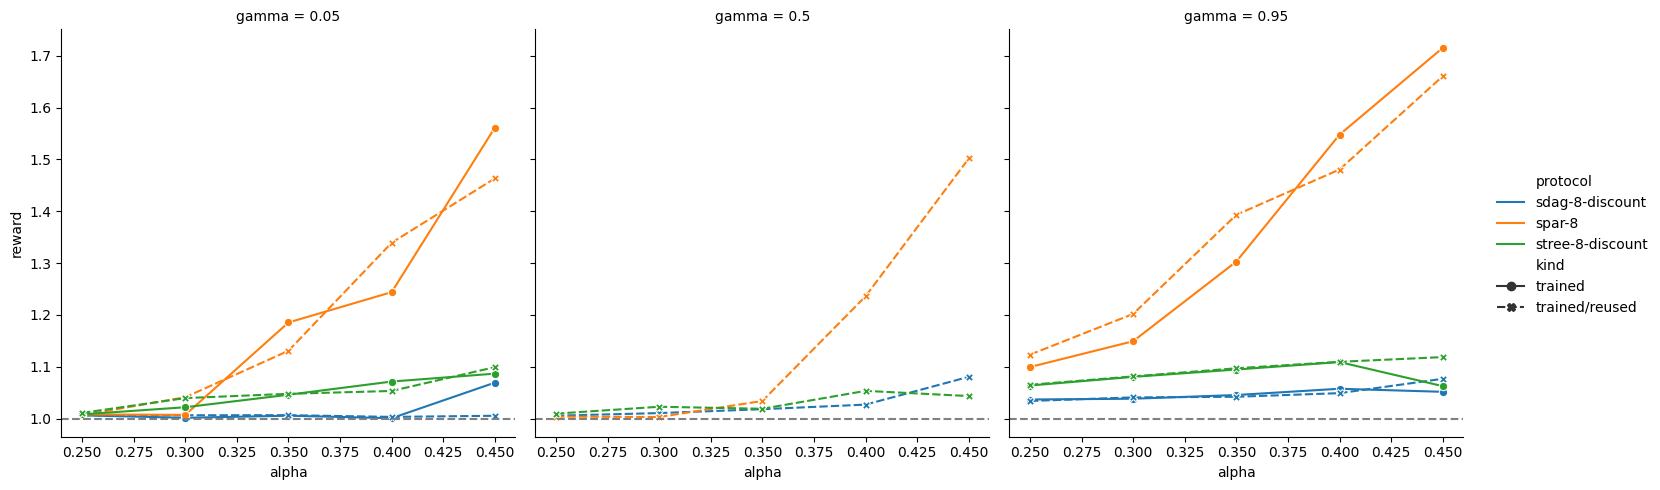

In [16]:
def rl_vs_hard_coded_alpha_lp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = d.query('kind != "hard-coded"')
    d = (
        d.assign(__=objective)
        .groupby(
            [
                "protocol",
                "family",
                "k",
                "reward",
                "subblock_selection",
                "alpha",
                "gamma",
                "kind",
                "reused",
                "policy",
            ]
        )["__"]
        .mean()
        .reset_index()
        .assign(
            kind=lambda d: d.kind.astype("category"),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )

    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="gamma",
        x="alpha",
        y=label,
        style="kind",
        markers=True,
    ).refline(y=1)


rl_vs_hard_coded_alpha_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)